# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

21:36:03 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=968617;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=533022;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=536111;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=796922;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

21:37:00 INFO      Auto-determined polynomial order: 0                                ]8;id=686549;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=114179;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

21:37:10 INFO      None 0-order polynomial fit with the mle method                               ]8;id=682802;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=440616;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=607945;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=17233;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=888040;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=983516;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=593197;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=328617;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=588178;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=582691;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=627386;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=75681;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=466261;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=258465;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=177529;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=279373;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=850928;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=880996;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

21:37:13 INFO      Now using 120 bins                                                          ]8;id=875210;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=345002;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

21:37:14 INFO      Auto-determined polynomial order: 1                                ]8;id=465282;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=718396;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

21:37:25 INFO      None 1-order polynomial fit with the mle method                               ]8;id=903721;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=221235;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=627557;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=225156;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=6955;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=63409;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=393960;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=819451;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=312238;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=565779;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

21:37:26 INFO      Auto-probed noise models:                                                    ]8;id=228737;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=777991;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=574238;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=304694;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=402506;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=613565;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=322795;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=488913;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=845341;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=967097;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

21:37:28 INFO      Auto-determined polynomial order: 1                                ]8;id=622258;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=222757;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

21:37:39 INFO      None 1-order polynomial fit with the mle method                               ]8;id=683701;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=102906;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=24092;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=363344;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=663021;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=39898;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:37:40 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=226661;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=484773;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=314336;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=271064;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

21:37:41 INFO      Auto-probed noise models:                                                    ]8;id=195770;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=196998;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=913759;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=242134;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=846124;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=856947;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=980232;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=247859;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=763858;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=553388;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

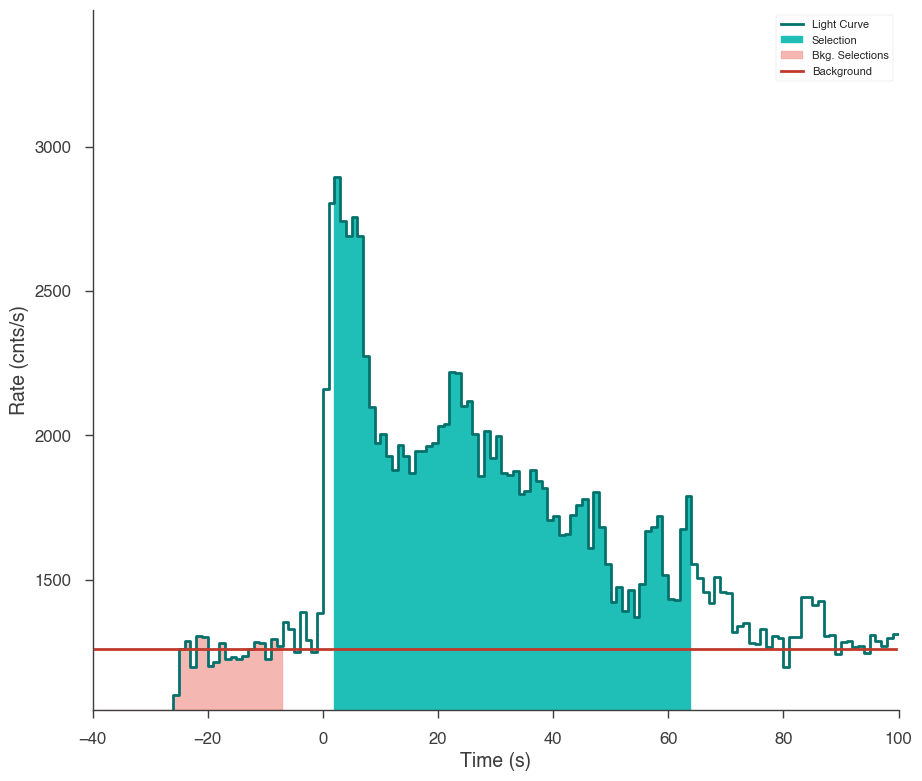

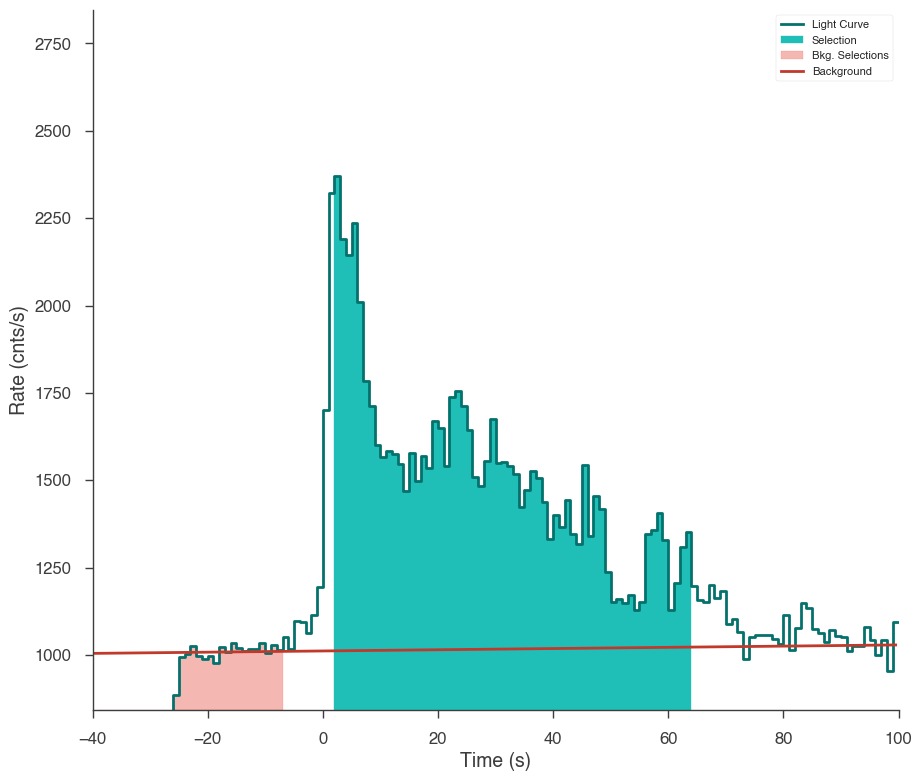

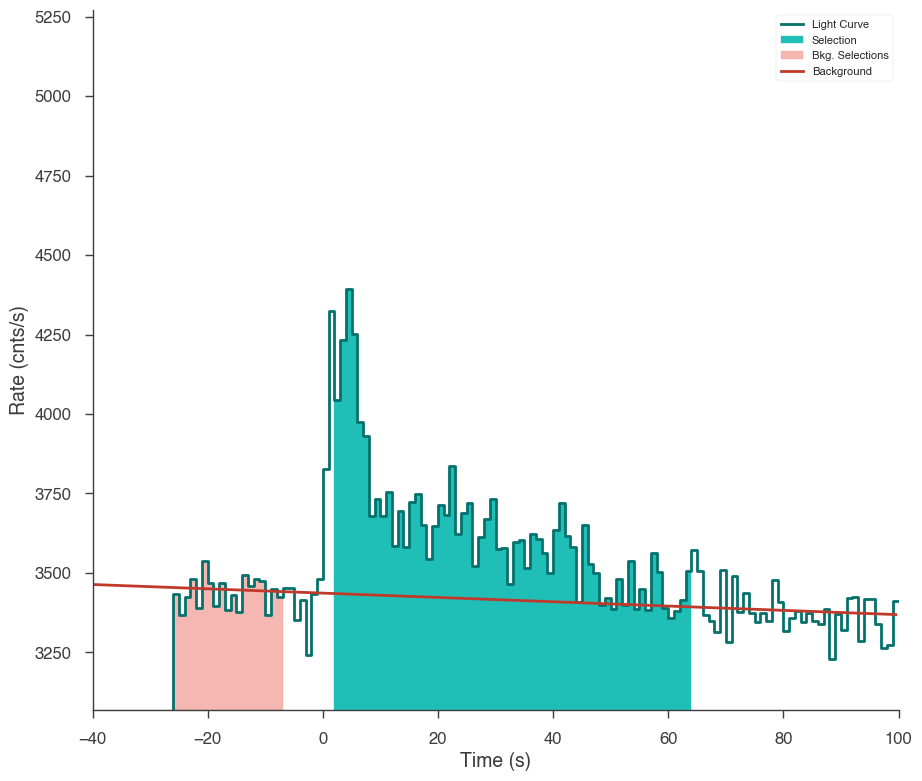

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):
        fluence_plugin.set_active_measurements("250-30000")

    else:
        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

21:37:42 INFO      sampler set to multinest                                                ]8;id=896176;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=136564;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

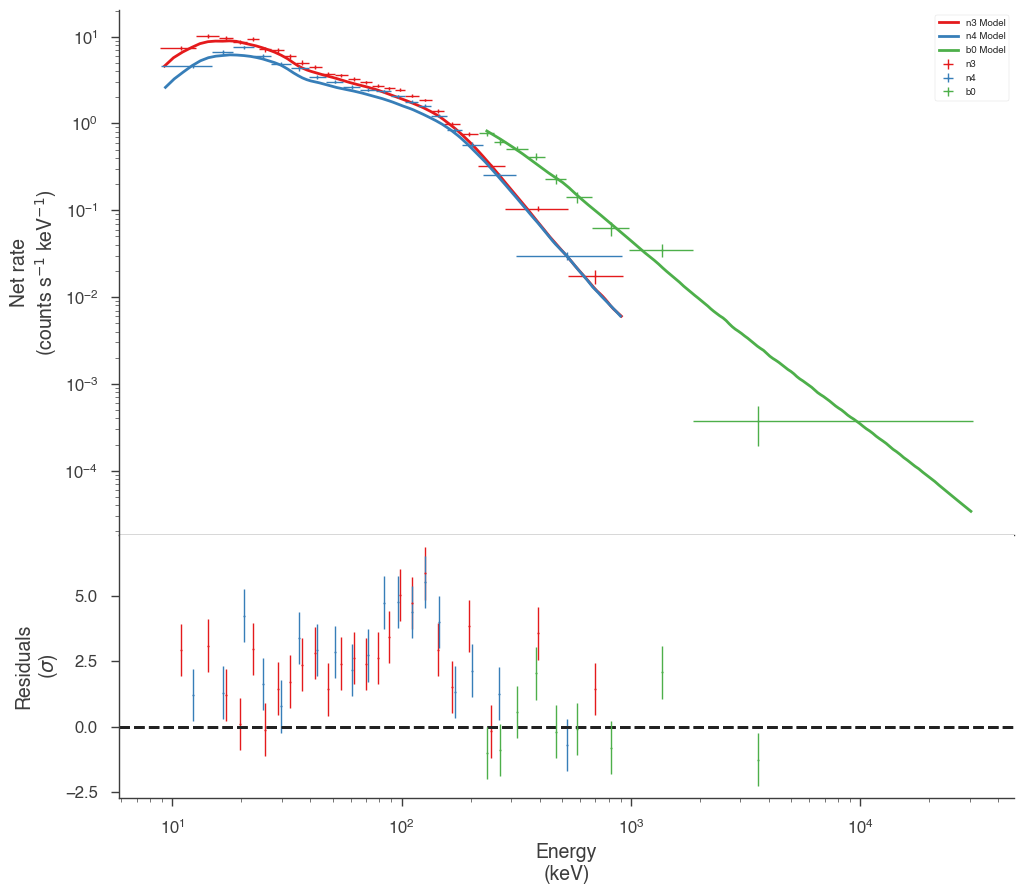

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


 ln(ev)=  -3101.9461038165327      +/-  0.22791158925198385     
 Total Likelihood Evaluations:        21408
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


21:38:12 INFO      fit restored to maximum of posterior                                         ]8;id=201435;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=544583;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=43896;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=637751;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
GRB080916009...K             (1.456 -0.006 +0.033) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha                   -1.101 +0.006 +0.04                 
GRB080916009...break_energy       (1.92 +0.04 +0.5) x 10^2              keV
GRB080916009...break_scale         (0.0 +1.5 +3.0) x 10^-1                 
GRB080916009...beta                    -1.973 -0.16 -0.017

Values of -log(posterior) at the minimum:

-log(posterior)
b0        -1050.763018
n3        -1020.083619
n4        -1011.760291
total     -3082.606928

Values of statistical measures:

statistical measures
AIC              6175.384310
BIC              6194.616520
DIC              6179.357336
PDIC                4.211065
log(Z)          -1347.158076

Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=405957;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=295916;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

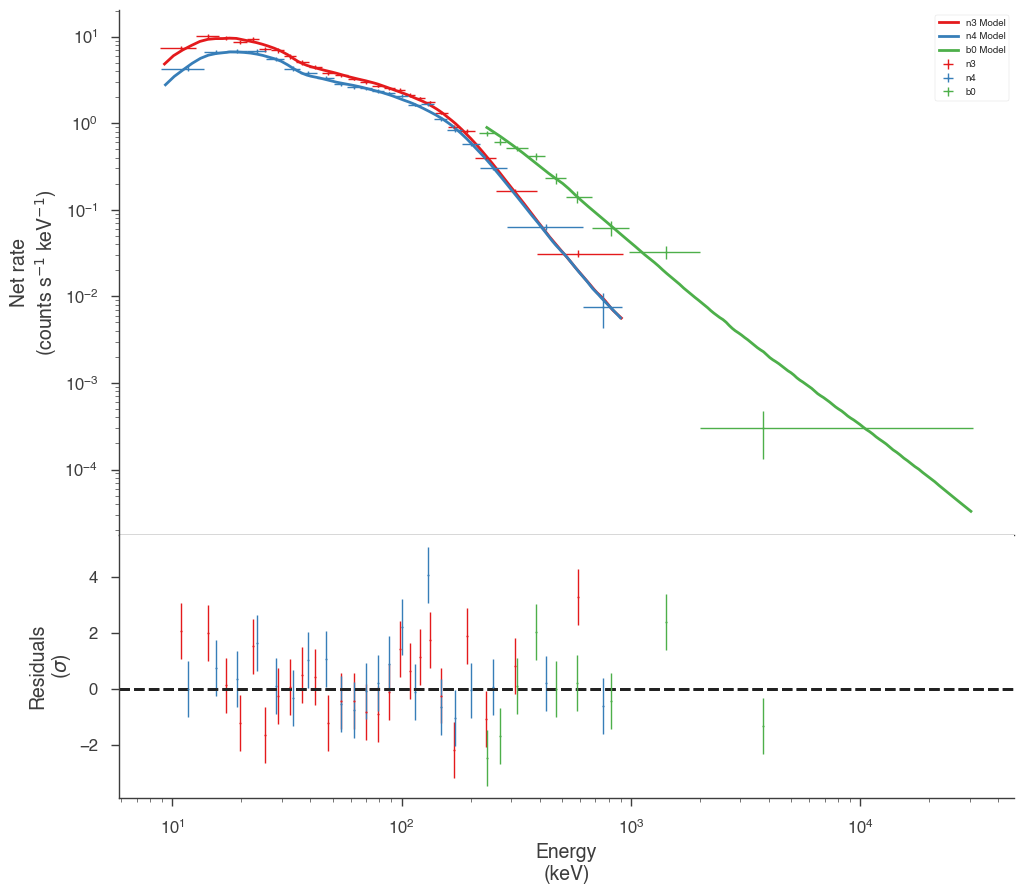

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

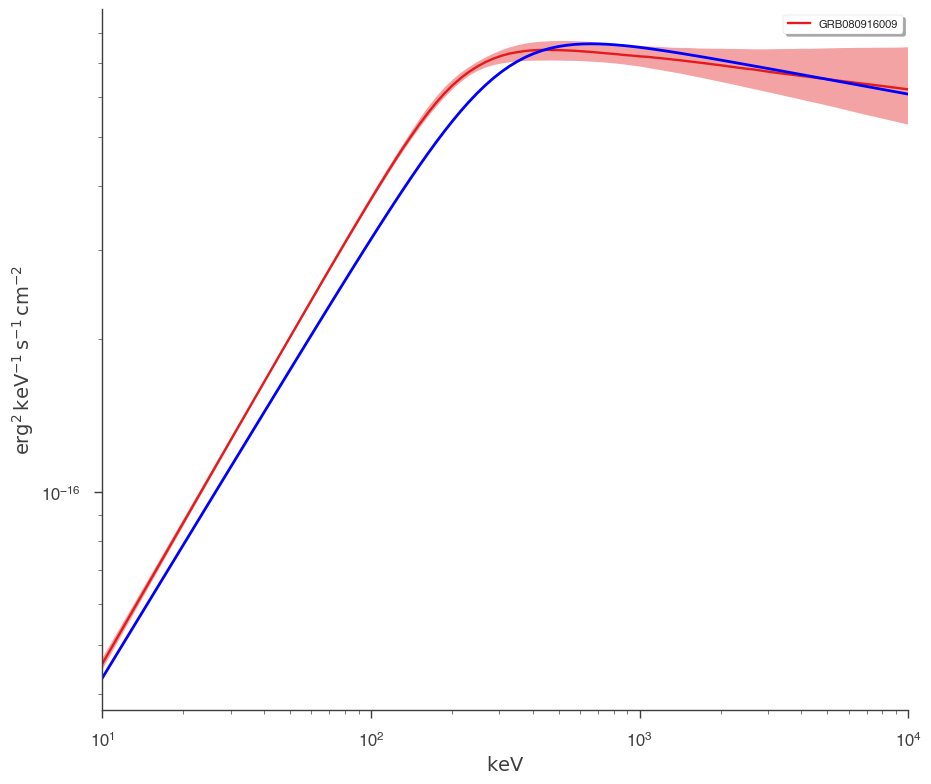

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

21:41:04 INFO      Created 15 bins via bayesblocks                                       ]8;id=525239;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=676043;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


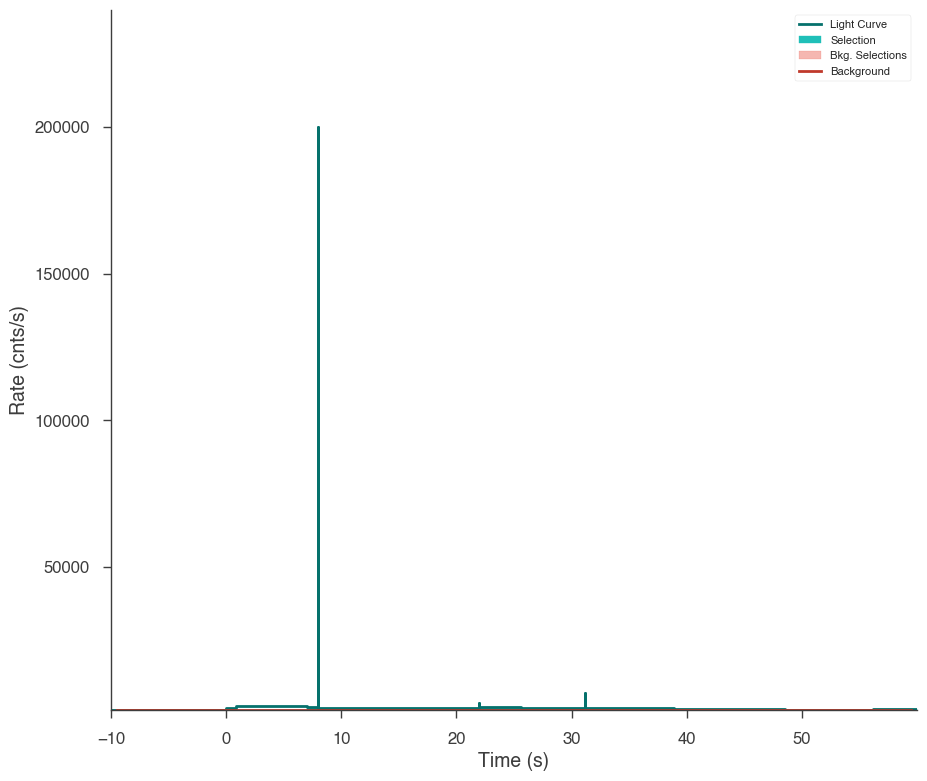

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):
    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):
    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

21:41:05 INFO      Created 12 bins via custom                                            ]8;id=882785;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=27521;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

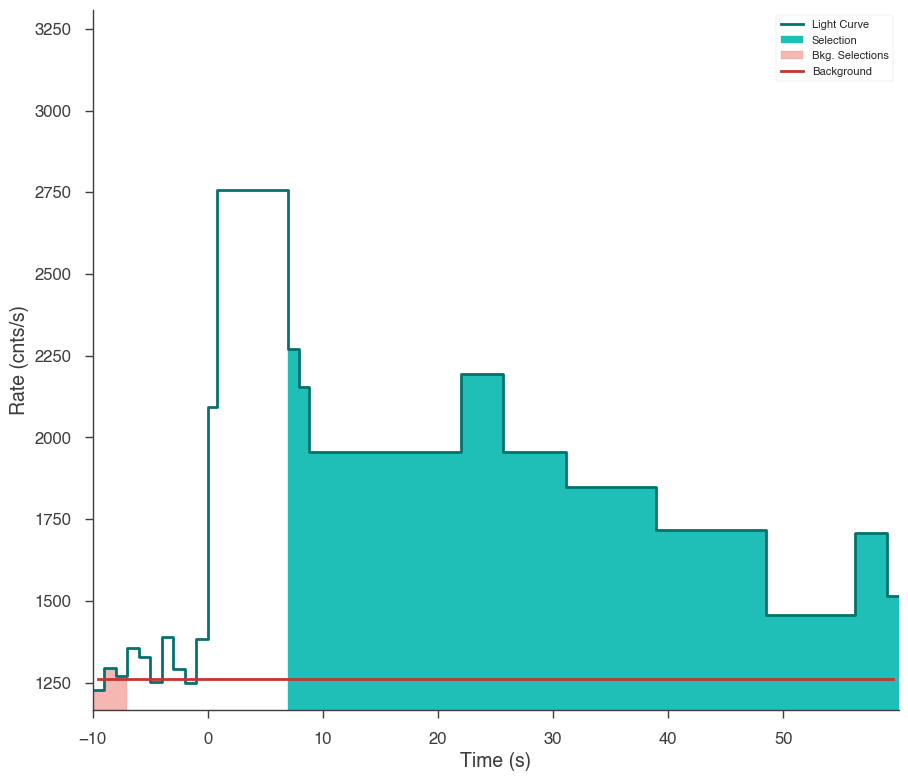

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=993974;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=286085;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

21:41:06 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=422631;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=497050;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=260619;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=197578;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

21:41:07 INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=864604;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=354750;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=957036;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=313212;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

21:41:08 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=131354;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=721097;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (None, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):
    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():
        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=203507;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=654550;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=983978;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=806218;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=66382;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=806379;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=464076;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=618014;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=731466;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=170344;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 107 bins                                                          ]8;id=458757;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=446472;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=141846;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=314180;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -789.50709245330870      +/-  0.18307344022046057     
 Total Likelihood Evaluations:        16735
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


21:41:24 INFO      fit restored to maximum of posterior                                         ]8;id=658116;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=659017;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=457615;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=542763;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (3.6 -0.6 +0.4) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-5.5 -1.5 +0.5) x 10^-1                 
grb.spectrum.main.Band.xp     (3.08 -0.32 +0.9) x 10^2              keV
grb.spectrum.main.Band.beta       -2.0332 -0.4 +0.0009

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval0      -285.660877
n3_interval0      -250.062588
n4_interval0      -267.939532
total             -803.662997

Values of statistical measures:

statistical measures
AIC              1615.439309
BIC              1630.848127
DIC              1569.532925
PDIC                1.696908
log(Z)           -342.878574

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=742688;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=419550;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=401178;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=966780;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=919678;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=747642;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=929879;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=831133;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=678612;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=26358;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=138948;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=244265;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=354453;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=274774;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1944.4496817871941      +/-  0.21764477394358012     
 Total Likelihood Evaluations:        23225
 Sampling finished. Exiting MultiNest



21:41:47 INFO      fit restored to maximum of posterior                                         ]8;id=698371;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=244916;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=76248;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=473686;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K      (4.124 +0.018 +0.19) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.594 -0.004 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp       (6.194 -0.6 -0.027) x 10^2              keV
grb.spectrum.main.Band.beta            -2.141 -0.032 +0.09

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval1      -673.822229
n3_interval1      -641.965639
n4_interval1      -645.331670
total            -1961.119538

Values of statistical measures:

statistical measures
AIC              3930.352390
BIC              3945.761208
DIC              3871.877452
PDIC                2.729848
log(Z)           -844.463767

21:41:48 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=675552;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=788251;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=46017;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=375613;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=447697;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=32789;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=246682;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=360418;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=759833;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=576017;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 115 bins                                                          ]8;id=932220;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=923076;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=791063;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=817758;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -907.27806774697774      +/-  0.19943692535283455     
 Total Likelihood Evaluations:        19962
 Sampling finished. Exiting MultiNest



21:42:07 INFO      fit restored to maximum of posterior                                         ]8;id=524316;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=328942;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=851158;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=709273;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.51 -0.18 +0.20) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha         -1.054 -0.07 +0.020                 
grb.spectrum.main.Band.xp         (6.0 -1.5 +2.1) x 10^2              keV
grb.spectrum.main.Band.beta            -1.88 -0.05 +0.16

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval2      -324.546965
n3_interval2      -289.197643
n4_interval2      -312.362281
total             -926.106890

Values of statistical measures:

statistical measures
AIC              1860.327094
BIC              1875.735911
DIC              1803.864094
PDIC                2.105142
log(Z)           -394.025858

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=260594;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=675370;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=746825;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=466114;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=573164;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=761428;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=943605;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=83739;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=646564;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=430276;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 109 bins                                                          ]8;id=192938;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=665345;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=184458;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=803532;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -787.73018076661049      +/-  0.17388576874675657     
 Total Likelihood Evaluations:        18204
 Sampling finished. Exiting MultiNest



21:42:27 INFO      fit restored to maximum of posterior                                         ]8;id=238237;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=112975;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=396744;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=305322;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                             
grb.spectrum.main.Band.K      (2.89 +/- 0.35) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-9.3 +/- 0.9) x 10^-1                 
grb.spectrum.main.Band.xp      (3.4 -0.5 +0.9) x 10^2              keV
grb.spectrum.main.Band.beta          -2.22 -0.5 +0.16

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval3      -298.398412
n3_interval3      -242.493383
n4_interval3      -262.487680
total             -803.379475

Values of statistical measures:

statistical measures
AIC              1614.872264
BIC              1630.281082
DIC              1570.964131
PDIC                3.215039
log(Z)           -342.106871

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=251767;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=946504;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=294525;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=222982;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=609845;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=502233;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=196826;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=535407;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=719158;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=736031;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=374727;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=916282;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=742972;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=723529;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2281.2841267105086      +/-  0.21631974031729753     
 Total Likelihood Evaluations:        22662
 Sampling finished. Exiting MultiNest



21:42:49 INFO      fit restored to maximum of posterior                                         ]8;id=89116;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=115425;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=513017;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=469864;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K        (2.47 +0.05 +0.22) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.690 +0.031 +0.6) x 10^-1                 
grb.spectrum.main.Band.xp      (2.811 -0.28 -0.032) x 10^2              keV
grb.spectrum.main.Band.beta           -1.848 -0.010 +0.006

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval4      -778.157404
n3_interval4      -759.522810
n4_interval4      -745.802516
total            -2283.482730

Values of statistical measures:

statistical measures
AIC              4575.078775
BIC              4590.487593
DIC              4536.021760
PDIC                1.540067
log(Z)           -990.749108

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=474860;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=231683;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=959577;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=901428;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=455497;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=34024;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=130072;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=20738;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=677916;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=471980;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=601033;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=989499;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=298899;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=395435;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1574.8763407781835      +/-  0.19990436004787321     
 Total Likelihood Evaluations:        19287
 Sampling finished. Exiting MultiNest



21:43:04 INFO      fit restored to maximum of posterior                                         ]8;id=250624;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=883737;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=694853;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=297134;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.82 -0.07 +0.27) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-9.05 -0.28 +0.7) x 10^-1                 
grb.spectrum.main.Band.xp       (4.12 -0.6 +0.24) x 10^2              keV
grb.spectrum.main.Band.beta            -2.15 -0.12 +0.11

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval5      -536.574106
n3_interval5      -523.633464
n4_interval5      -527.688437
total            -1587.896008

Values of statistical measures:

statistical measures
AIC              3183.905330
BIC              3199.314147
DIC              3134.809039
PDIC                2.328424
log(Z)           -683.960104

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=192544;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=580094;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=92230;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=18967;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=104325;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=91073;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=312656;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=25003;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=34388;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=417637;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=508201;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=934412;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=205449;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=17015;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1755.8254796948377      +/-  0.19522266471131902     
 Total Likelihood Evaluations:        18814
 Sampling finished. Exiting MultiNest



21:43:18 INFO      fit restored to maximum of posterior                                         ]8;id=408550;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=891275;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=499497;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=370695;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.98 -0.14 +0.10) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.00 -0.05 +0.04                 
grb.spectrum.main.Band.xp         (4.3 -0.4 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta            -2.36 -0.11 +0.21

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval6      -609.344799
n3_interval6      -584.364965
n4_interval6      -576.665446
total            -1770.375210

Values of statistical measures:

statistical measures
AIC              3548.863734
BIC              3564.272552
DIC              3499.702622
PDIC                2.708743
log(Z)           -762.545317

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=506877;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=533054;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=275277;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=909045;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=60103;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=379339;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=29956;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=998639;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=300527;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=138248;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=520548;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=649662;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=197001;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=983001;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -1939.1983379893891      +/-  0.19131541196403148     
  analysing data from chains/fit-.txt
 Total Likelihood Evaluations:        19347
 Sampling finished. Exiting MultiNest


21:43:31 INFO      fit restored to maximum of posterior                                         ]8;id=279662;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=581990;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=503594;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=418421;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.67 -0.12 +0.09) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.04 -0.05 +0.04                 
grb.spectrum.main.Band.xp         (4.3 -0.5 +0.9) x 10^2              keV
grb.spectrum.main.Band.beta             -2.23 -0.5 +0.10

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval7      -662.313183
n3_interval7      -640.935978
n4_interval7      -650.254005
total            -1953.503166

Values of statistical measures:

statistical measures
AIC              3915.119646
BIC              3930.528463
DIC              3869.054300
PDIC                3.413151
log(Z)           -842.183138

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=7981;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=222967;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=947953;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=35941;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=27264;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=516451;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=455616;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=187340;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=582997;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=880178;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=837260;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=122824;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=210972;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=615849;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2056.4018117209694      +/-  0.19946448570410666     
 Total Likelihood Evaluations:        17928
 Sampling finished. Exiting MultiNest



21:43:45 INFO      fit restored to maximum of posterior                                         ]8;id=810446;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=786715;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=214784;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=225696;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K      (1.553 +0.010 +0.16) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.378 -0.012 +0.7) x 10^-1                 
grb.spectrum.main.Band.xp       (3.674 -0.5 +0.008) x 10^2              keV
grb.spectrum.main.Band.beta              -2.30 -0.10 +0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval8      -702.128829
n3_interval8      -698.491389
n4_interval8      -666.026257
total            -2066.646475

Values of statistical measures:

statistical measures
AIC              4141.406265
BIC              4156.815082
DIC              4095.592278
PDIC                1.912718
log(Z)           -893.083959

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=854899;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=747242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=772872;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=708398;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=192199;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=71643;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=452832;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=370557;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=926692;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=209462;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=714110;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=368841;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=232841;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=461255;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1878.8456523108289      +/-  0.14687651210614547     
 Total Likelihood Evaluations:        12343
 Sampling finished. Exiting MultiNest



21:43:54 INFO      fit restored to maximum of posterior                                         ]8;id=936300;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=940411;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=552300;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=908989;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                             
grb.spectrum.main.Band.K      (1.1 -0.4 +1.7) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-8.7 -2.0 +4) x 10^-1                 
grb.spectrum.main.Band.xp      (1.1 -0.5 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta          -1.87 -0.4 +0.14

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval9      -648.348168
n3_interval9      -616.975614
n4_interval9      -616.271611
total            -1881.595393

Values of statistical measures:

statistical measures
AIC              3771.304101
BIC              3786.712919
DIC              3642.788780
PDIC             -104.497114
log(Z)           -815.972299

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=868958;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=414698;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=168181;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=974199;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=41273;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=236925;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=20933;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=479493;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=860543;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=87377;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

21:43:55 INFO      Now using 119 bins                                                          ]8;id=187907;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=133391;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=32072;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=706251;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1322.1419776755263      +/-  0.16669076197844843     
 Total Likelihood Evaluations:        15346
 Sampling finished. Exiting MultiNest



21:44:08 INFO      fit restored to maximum of posterior                                         ]8;id=898972;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=702553;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=432207;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=901593;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (1.99 -0.20 +0.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-7.5 -0.7 +1.6) x 10^-1                 
grb.spectrum.main.Band.xp      (2.27 -0.5 +0.33) x 10^2              keV
grb.spectrum.main.Band.beta           -1.99 -0.30 +0.17

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval10      -460.854492
n3_interval10      -437.707461
n4_interval10      -433.428329
total             -1331.990283

Values of statistical measures:

statistical measures
AIC              2672.093879
BIC              2687.502697
DIC              2635.150410
PDIC                1.532171
log(Z)           -574.198965

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=194223;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=230550;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=492096;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=340133;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=156948;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=332689;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=937631;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=319703;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=752;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=801897;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=805571;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=484902;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=965041;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=675209;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -813.27845935179198      +/-  0.15250730817324543     
 Total Likelihood Evaluations:        12327
 Sampling finished. Exiting MultiNest



21:44:20 INFO      fit restored to maximum of posterior                                         ]8;id=242895;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=652557;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=297229;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=474527;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (3.1 -1.5 +2.2) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-4.3 -4 +2.1) x 10^-1                 
grb.spectrum.main.Band.xp     (1.22 -0.33 +0.4) x 10^2              keV
grb.spectrum.main.Band.beta          -2.07 -0.08 +0.20

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval11      -292.374635
n3_interval11      -272.417511
n4_interval11      -255.836941
total              -820.629087

Values of statistical measures:

statistical measures
AIC              1649.371489
BIC              1664.780307
DIC              1607.902984
PDIC               -9.085942
log(Z)           -353.202347

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=287390;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=169965;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

21:44:21 INFO      fit restored to median of posterior                                          ]8;id=100750;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=846136;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

21:44:22 INFO      fit restored to median of posterior                                          ]8;id=632762;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=33704;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

21:44:23 INFO      fit restored to median of posterior                                          ]8;id=379695;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=305532;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

21:44:25 INFO      fit restored to median of posterior                                          ]8;id=673912;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=679455;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=623933;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=460473;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

21:44:26 INFO      fit restored to median of posterior                                          ]8;id=421174;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=837439;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

21:44:27 INFO      fit restored to median of posterior                                          ]8;id=191890;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=571857;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

21:44:28 INFO      fit restored to median of posterior                                          ]8;id=714394;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=311179;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=468177;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=871633;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

21:44:29 INFO      fit restored to median of posterior                                          ]8;id=930195;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=441574;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

21:44:30 INFO      fit restored to median of posterior                                          ]8;id=843304;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=194634;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

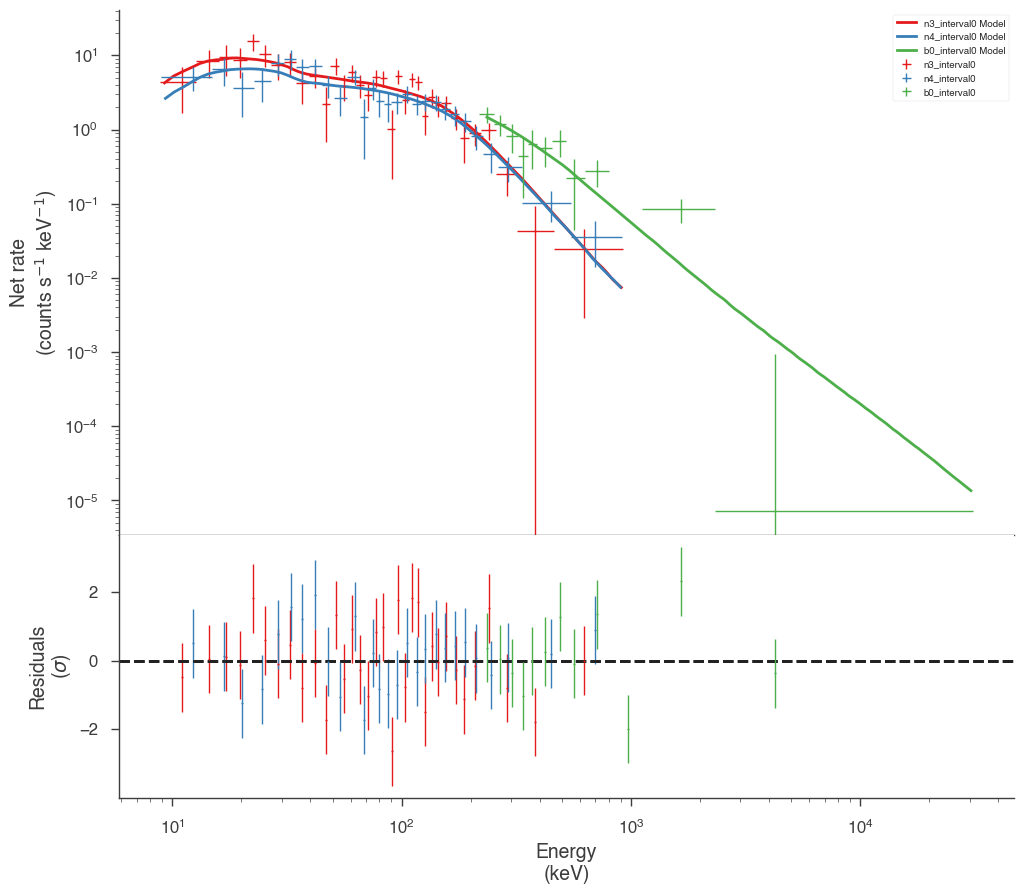

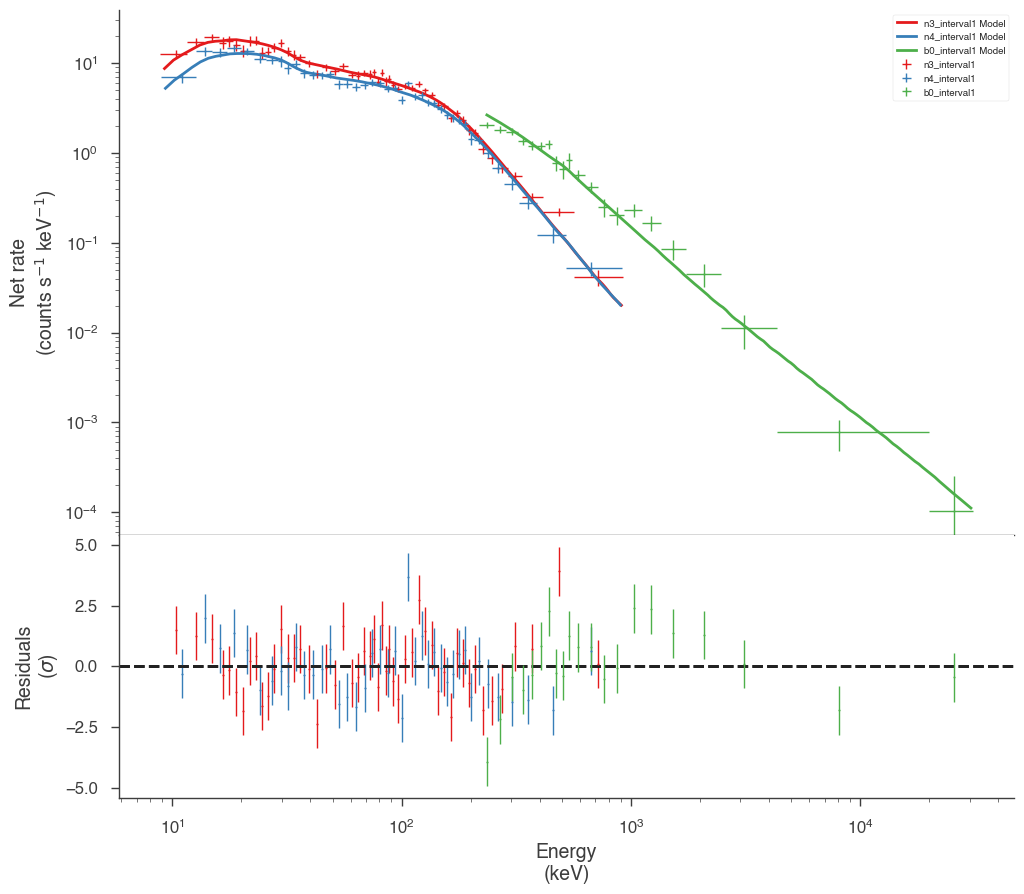

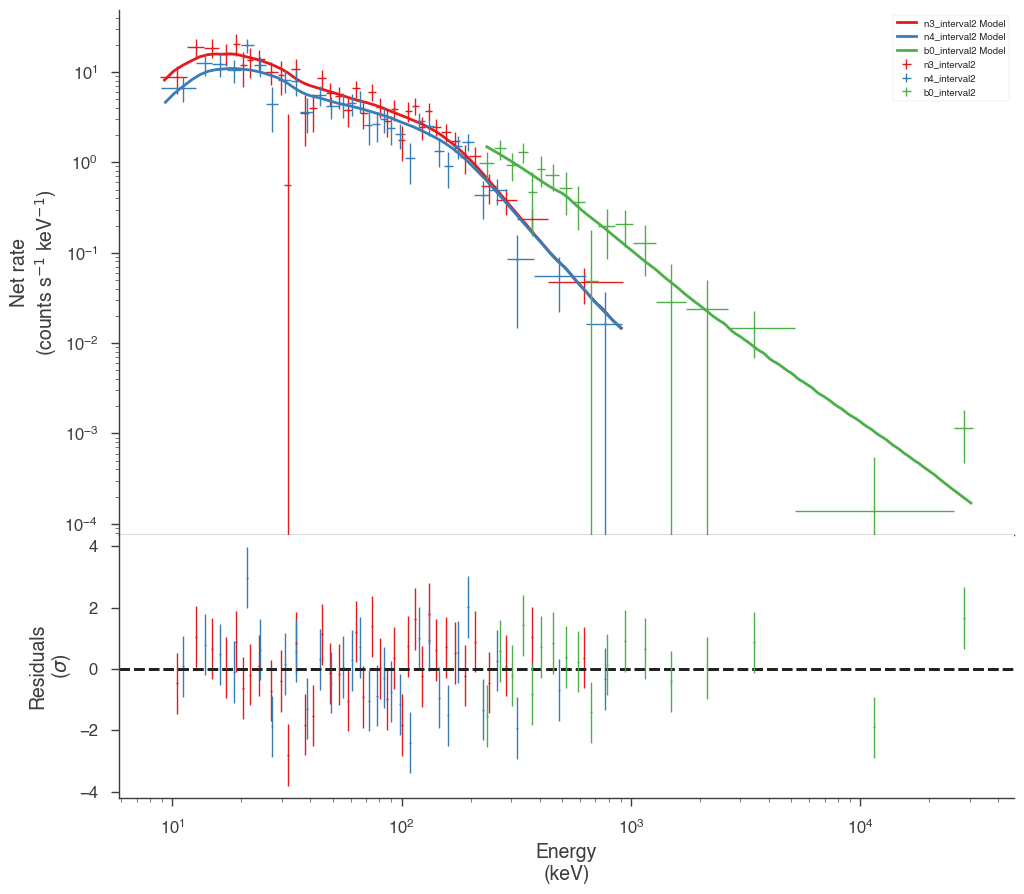

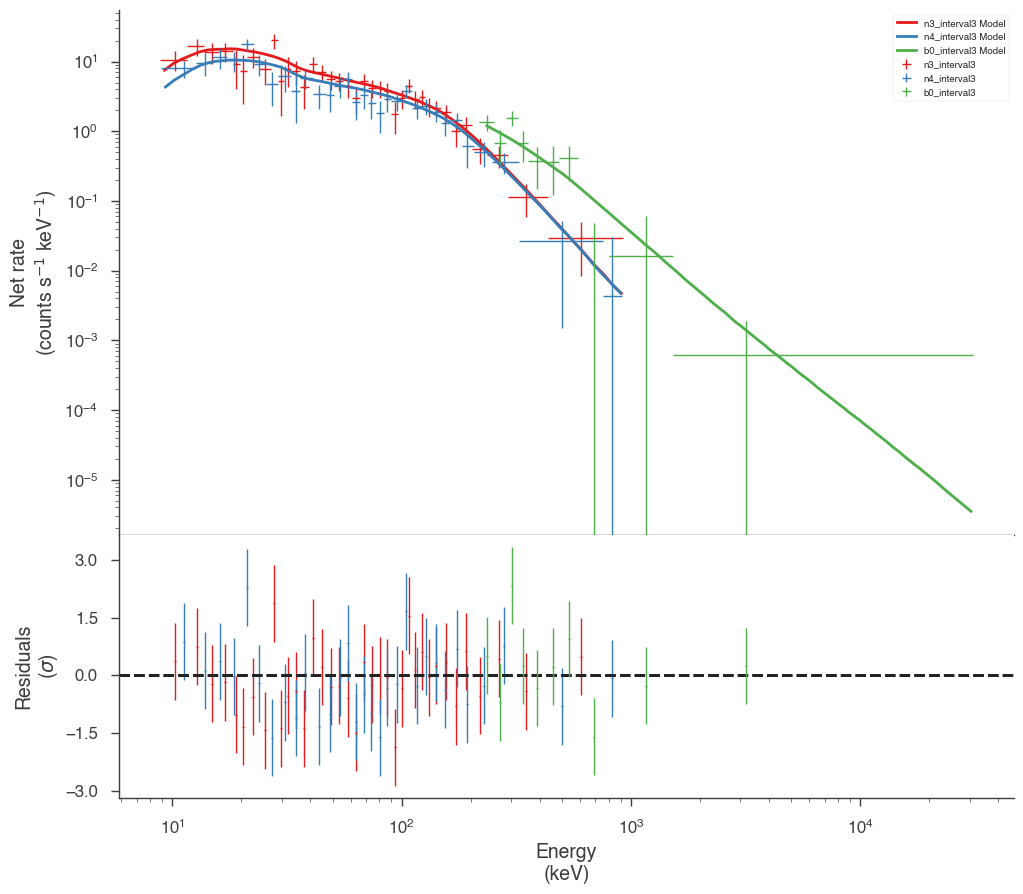

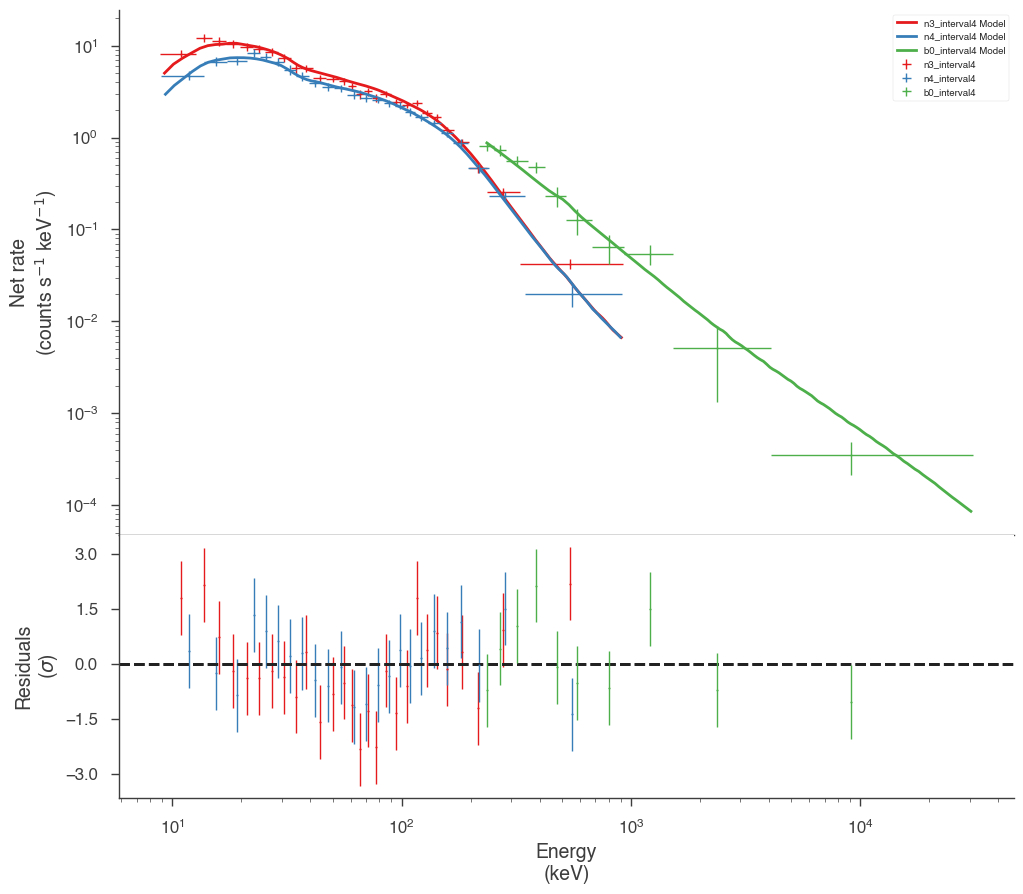

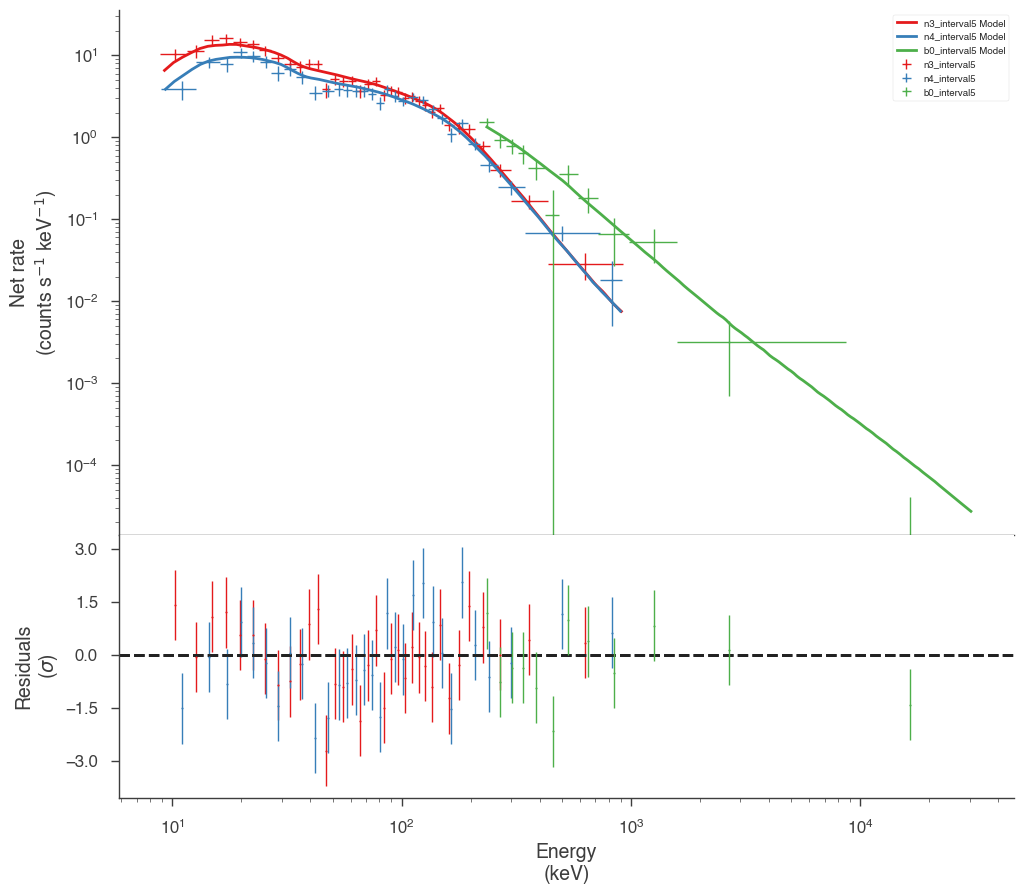

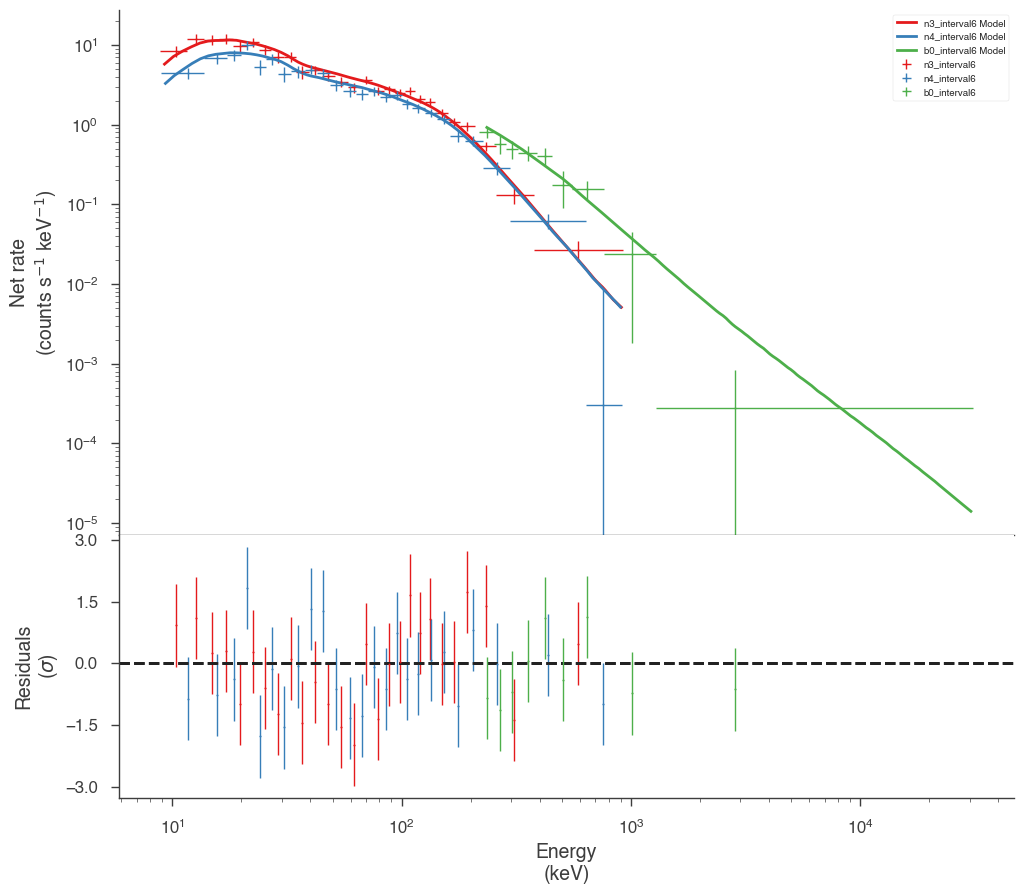

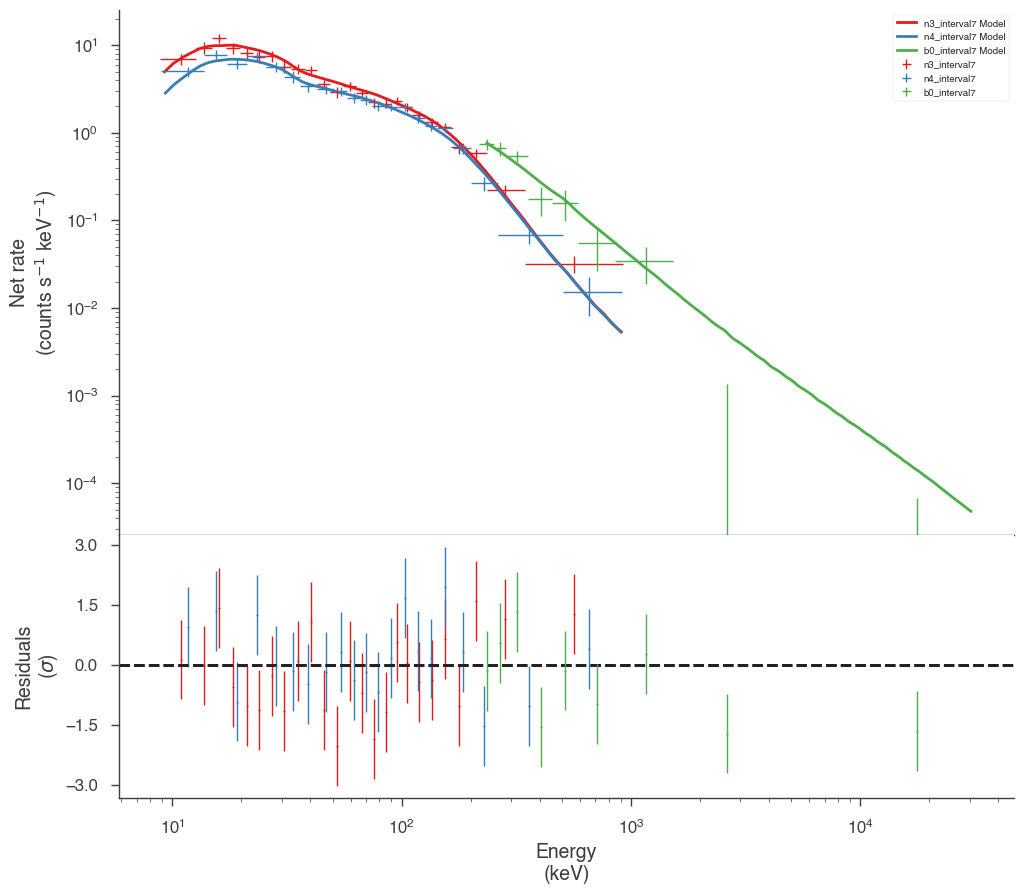

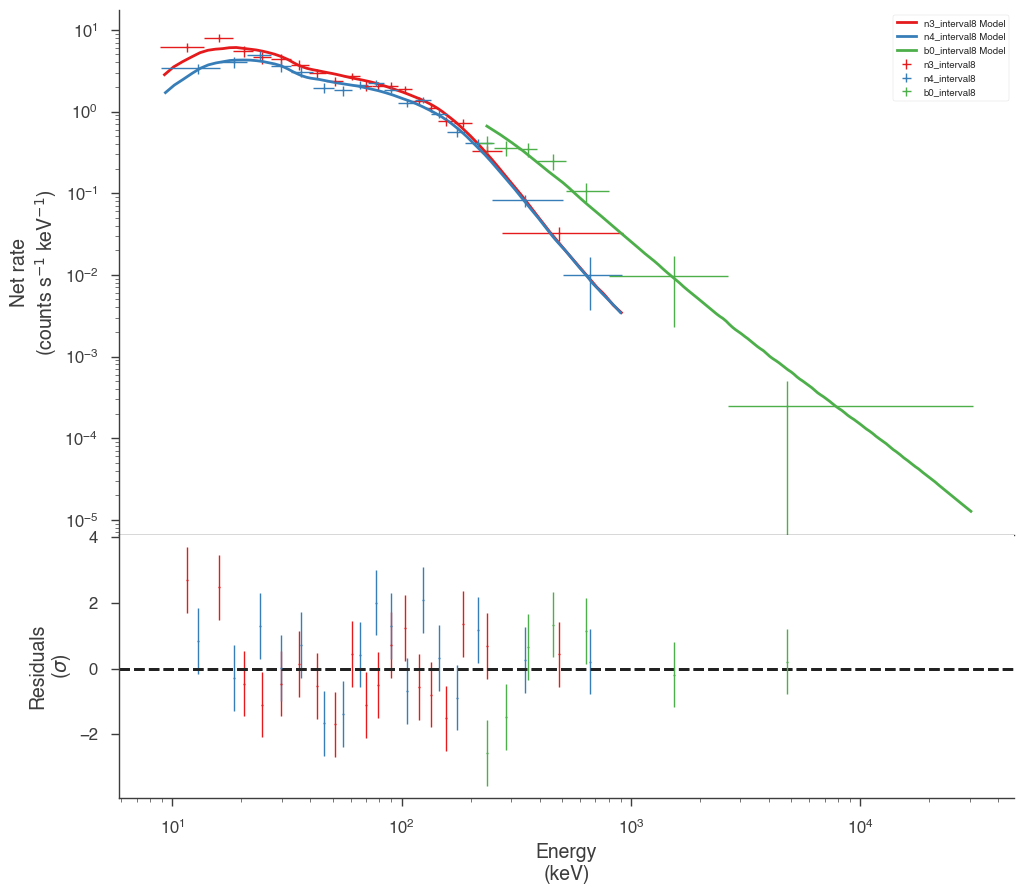

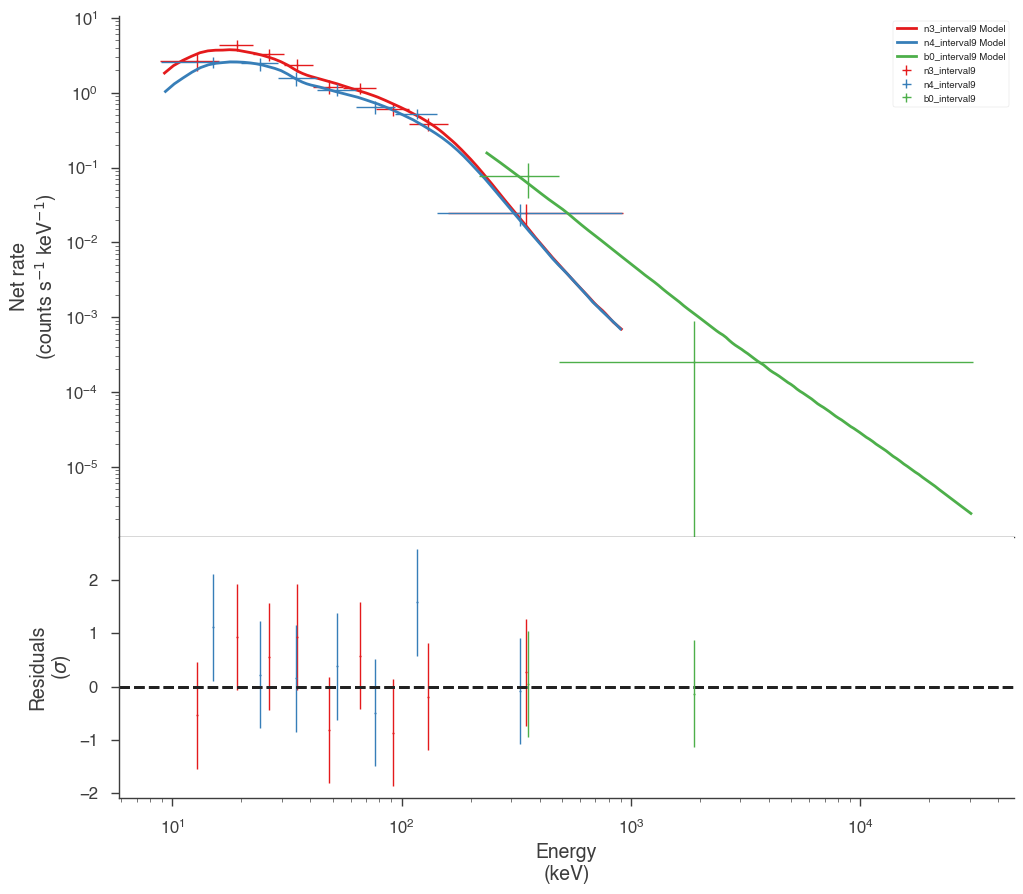

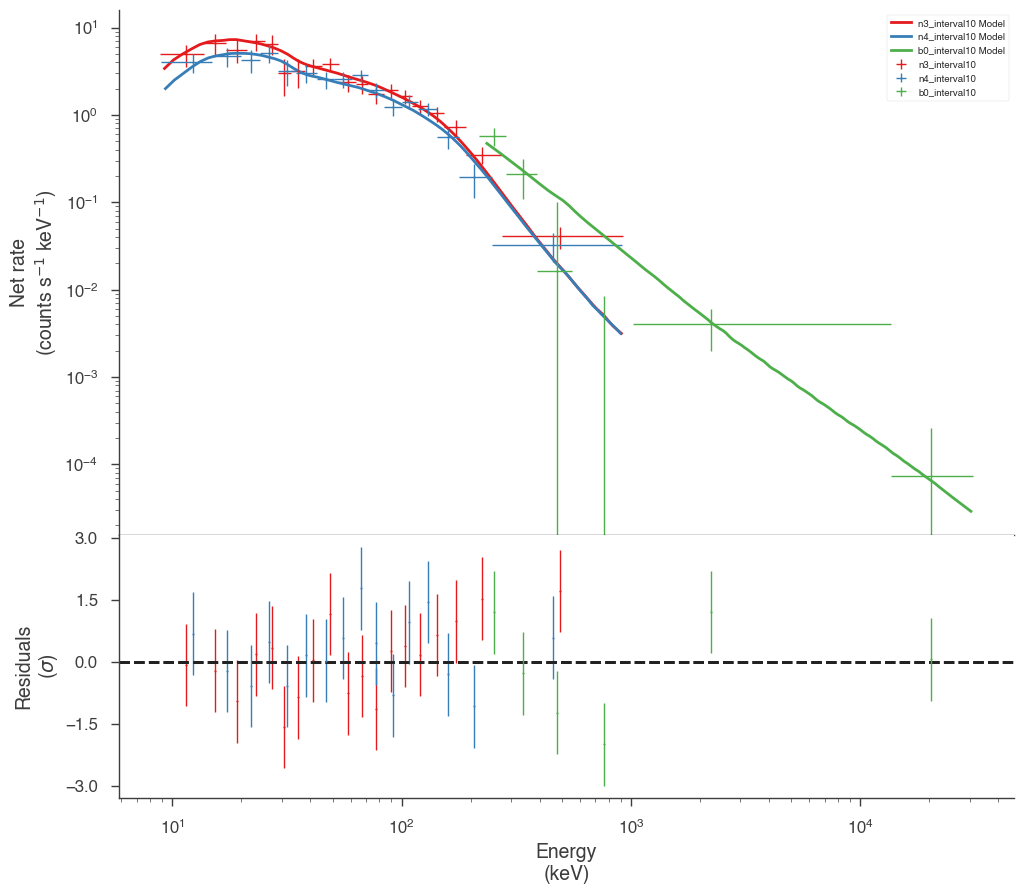

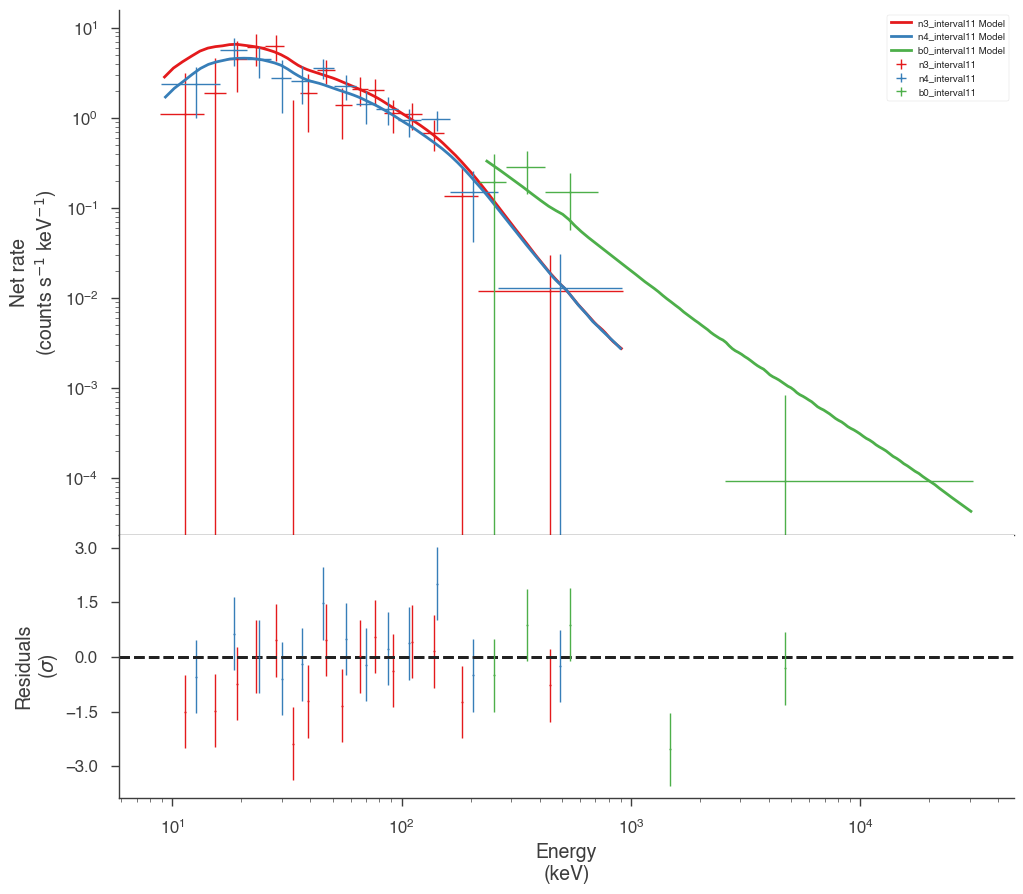

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

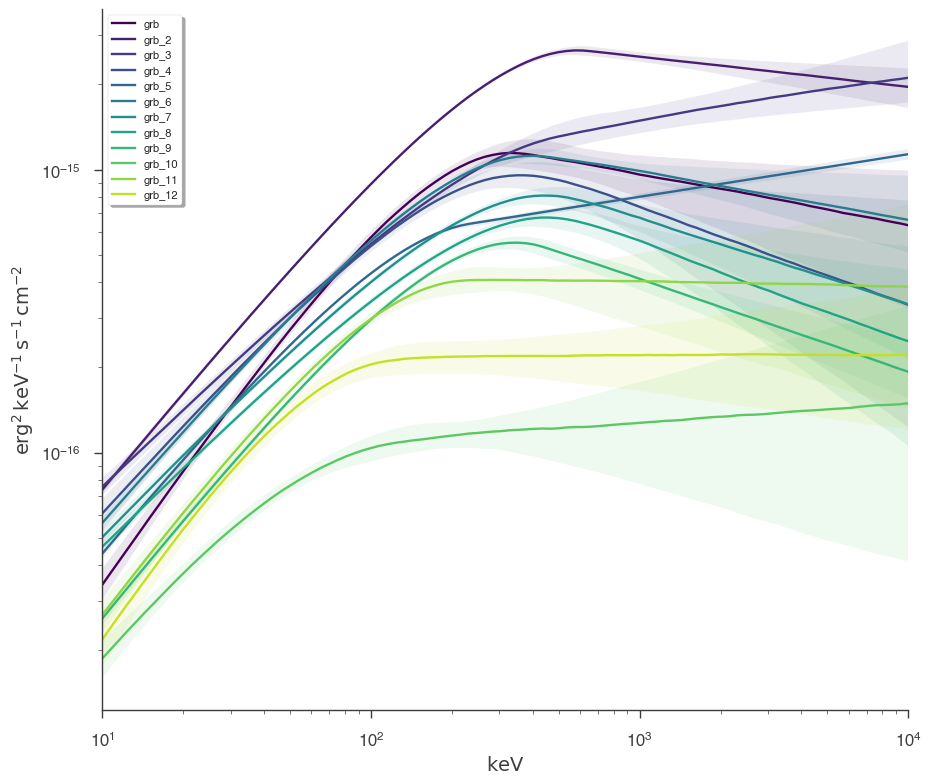

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.